## Ingeniería y Selección de Variables - Parte II

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## Reducción de Dimensionalidad

### Análisis de Componentes Principales (PCA)

Puede ser demostrado que los componentes principales de un conjunto de datos son los vectores propios de la matrix de covarianza del conjunto de datos. Por lo tanto, los componentes principales son comunmente calculados usando la descomposición SVD de la matriz de datos. 

Si $X \in \mathbb R^{n \times p}$, entonces $A$ puede ser factorizada como:
$$
    X = U\Sigma V^{T}
$$

donde,
* $U \in \mathbb R^{m \times m}$ es una matriz cuyas columnas son los vectores propios de $XX^{T}$
* $V \in \mathbb R^{n \times n}$ es una matriz cuyas columnas son los vectores propios de $X^{T}X$
* $\Sigma \in \mathbb R^{m \times n}$ es una matriz diagonal con elementos $\sigma_{1}, \sigma_{2}, \sigma_{3}, ... \sigma_{r}$ donde $r = rank(X)$ y corresponde a la raiz cuadrada de los valores propios de $X^{T}X$. Estos son llamados los valores singalres de $X$ y son valores no negativos ordenados descendentemente. ($\sigma_{1} \geq \sigma_{2} \geq \sigma_{3} \geq ... \sigma_{r} \geq 0$).

SVD proporciona un marco de trabajo muy útil para calcular una aproximación de bajo rango para $X$.

In [2]:
# Define some constants needed for the conversion.
Esun_Ch_01 = 726.721072
d2 = 0.3

scene = "OR_ABI-L1b-RadM1-M3C01_G16_s20171931811268_e20171931811326_c20171931811369.nc"
g16nc = Dataset(scene, 'r')
radiance_1 = g16nc.variables['Rad'][:]
g16nc.close()
g16nc = None
ref_1 = (radiance_1 * np.pi * d2) / Esun_Ch_01
# Make sure all data is in the valid data range
ref_1 = np.maximum(ref_1, 0.0)
ref_1 = np.minimum(ref_1, 1.0)
ref_gamma = np.sqrt(ref_1)

Rango de la matrix X: 844
Dimensiones de la matrix X: (1000, 1000)


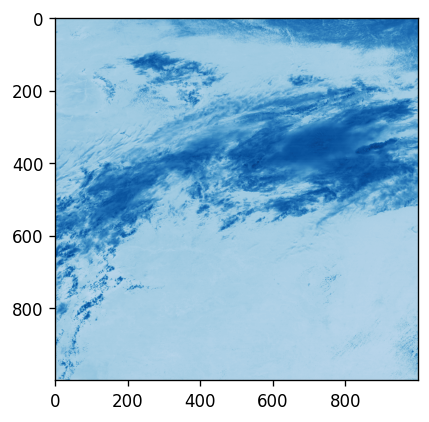

In [3]:
X = ref_gamma.data
rank_X = np.linalg.matrix_rank(X)
print("Rango de la matrix X: %s" % rank_X)
print("Dimensiones de la matrix X: %s" % str(X.shape))
fig = plt.figure(dpi=120)
im = plt.imshow(X, vmin=0.0, vmax=1.0, cmap='Blues')
plt.show()

In [4]:
# Red channel
U, S, VT = np.linalg.svd(X, full_matrices=True)
m, n = U.shape

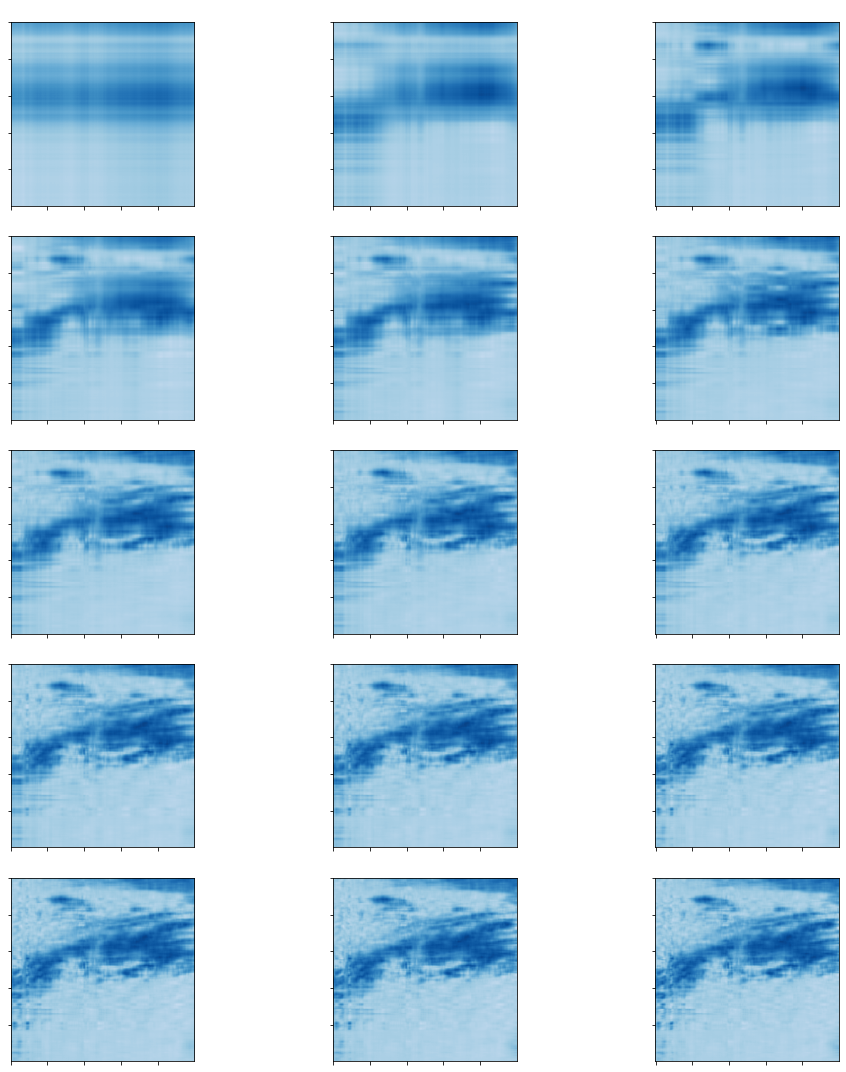

In [5]:
fig = plt.figure(figsize=(15, 15))

# First 16 components
for i in range(1, 16):
    s = np.concatenate((S[:i], np.zeros((n-i),)))
    A_p = np.dot(np.dot(U, np.diag(s)[:n,]), VT)
    
    ax = fig.add_subplot(5, 3, i)
    ax.imshow(A_p, cmap='Blues', vmin=0, vmax=1.0)
    ax.set_title('Component = %s' % i, color="white")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()

In [6]:
pca = PCA(n_components=16, svd_solver='arpack')
X_p = pca.fit_transform(X)
print(X_p.shape)
print("Rango de la matrix :%s" % np.linalg.matrix_rank(X_p))

(1000, 16)
Rango de la matrix :16


### Modelos Lineales Generalizados

Los Modelos Lineales Generalizados son usados para crear un modelo lineal que se relaciona mediante una función de enlace con los parámetros de una distribución de la familia exponencial. Es decir, este modelo describe como el valor esperado $\mu_y$ cambia en función de las variables explanatorias. 

Usando los p-values para cada variable exógena, podemos determinar si tenemos evidencia para aceptar o rechazar la hipótesis de que cada variable particular afecta la variable de respuesta. 

#### Regresión Logística
Cuando nuestras variables toman valores discretos con un número superior, es decir nuestra variable es categórica, construímos un modelo de regresión logística donde nuestra función de enlace es Binomial. 

```
y = glm(X, family=Binomial)
```


#### Regression Poisson

Por ejemplo, cuando nuestras variables toman valores discretos sin límite superior, es decir, el número de ocurrencias de algún evento en un intervalo de tiempo o espacio, estás variables se pueden modelar usando distribución de Poisson, es decir, nuestra variable dependiente es discreta no-negativa y que sigue una distribución de Poisson. 

```
y = glm(X, family=Poisson)
```


#### Regression Gamma
La función de enlace Gamma es comúnmente usada en variables continuas positivas, e.g. precios, tiempos de servicio, etc. Generalmente se usa en variables que son asimétricas (skewed).

```
y = glm(X, family=Gamma)
```

Después de generar el modelo GLM, vamos a probar subconjuntos de las variables de regression usando el Likelihood Ratio Test (LRT). Esto significa que vamos a comparar el modelo completo vs un modelo restringido donde algunas variables explanatorias son omitidas. 

In [7]:
x1 = np.arange(10)
x2 = 0.5 * np.arange(9, 4, -0.5)
x3 = np.array([4.7, 9.8, 6.5, 6.7, 1.4, 0.0, 5.7, 0.3, 9.1, 5.1])
x4 = np.arange(10, 20)
y = np.array([2.68, 2.66, 2.92, 2.86, 2.9, 2.92, 3.07, 3.03, 2.94, 3.02])
X = np.vstack([x1, x2, x3, x4]).T


threshold=0.05
n, p = X.shape
X = sm.add_constant(X, prepend=True)
glm = sm.GLM(
    y, X, family=sm.families.Gamma()).fit(maxiter=500)
pvalues = glm.pvalues
glm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   10
Model:                            GLM   Df Residuals:                        7
Model Family:                   Gamma   Df Model:                            2
Link Function:          inverse_power   Scale:                      0.00084712
Method:                          IRLS   Log-Likelihood:                 12.088
Date:                Wed, 21 Apr 2021   Deviance:                    0.0058518
Time:                        17:36:48   Pearson chi2:                  0.00593
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.000     30.606      0.000       0.004       0.005
x1            -0.0217      0.001    -18.790      0.000      -0.024      -0.019
x2             0.0259      0.001     27.186      0.000       0.024       0.028
x3             0.0010      0.001      1.044      0.297      -0.001       0.003
x4             0.0238      0.000     54.218      0.000       0.023       0.025
==============================================================================
"""

In [8]:
to_keep = np.arange(p)
final = None
sel = np.argmax(pvalues)
if pvalues[sel] < threshold:
    final = glm
else:
    mask = [0, sel]
    pvalues = np.delete(pvalues, mask)
    dat = np.delete(X, mask, axis=1)
    to_keep = np.delete(to_keep, sel)

    i = 0
    while not final:
        dat = sm.add_constant(dat, prepend=True)
        glm = sm.GLM(
            y, dat, family=sm.families.Gamma()
        ).fit(maxiter=500)
        i = i + 1
        k = p - i + 1
        if k == 1:
            break
        else:
            pvalues = glm.pvalues
            sel = np.argmax(pvalues)
            if pvalues[sel] < threshold:
                final = glm
                break
            else:
                mask = [0, sel]
                pvalues = np.delete(pvalues, mask)
                dat = np.delete(dat, mask, axis=1)
                to_keep = np.delete(to_keep, sel)

if not final:
    raise RuntimeError("No variables were selected")

X_p = final.model.exog[:, 1:]
to_drop = [el for el in np.arange(p) if el not in to_keep]
print("Variables a eliminar: %s" % str(to_drop))

Variables a eliminar: [3]
